# Satellite Image Segmentation with Inria and fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path('AerialImageDataset/train')
path.ls()

[PosixPath('AerialImageDataset/train/valid_pl'),
 PosixPath('AerialImageDataset/train/gt'),
 PosixPath('AerialImageDataset/train/valid_patches'),
 PosixPath('AerialImageDataset/train/large_pl'),
 PosixPath('AerialImageDataset/train/large_patches'),
 PosixPath('AerialImageDataset/train/test_patches'),
 PosixPath('AerialImageDataset/train/valid_preds'),
 PosixPath('AerialImageDataset/train/preds_fix'),
 PosixPath('AerialImageDataset/train/fix.tif'),
 PosixPath('AerialImageDataset/train/test_preds'),
 PosixPath('AerialImageDataset/train/images')]

In [4]:
path_lbl = path / 'gt'
path_img = path / 'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('AerialImageDataset/train/images/chicago35.tif'),
 PosixPath('AerialImageDataset/train/images/vienna25.tif'),
 PosixPath('AerialImageDataset/train/images/vienna19.tif')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('AerialImageDataset/train/gt/chicago35.tif'),
 PosixPath('AerialImageDataset/train/gt/vienna25.tif'),
 PosixPath('AerialImageDataset/train/gt/vienna19.tif')]

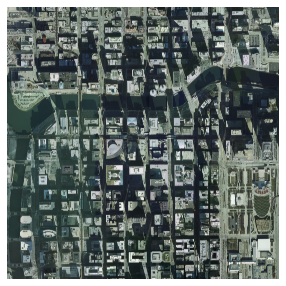

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

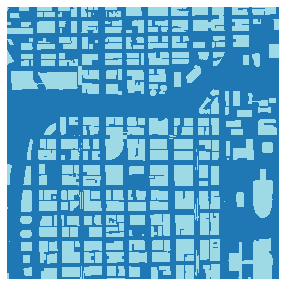

In [9]:
mask = open_mask(path_lbl / img_f.name)
mask.show(figsize=(5, 5), alpha=1)

# Create image patches

In [9]:
import cv2
import torchvision.transforms.functional as tvf

class Patcher(object):
    
    def __init__(self, img_size, patch_size, overlap_pct):
        self.img_size = img_size
        self.patch_size = patch_size
        self.overlap_pct = overlap_pct
        self.step = int(self.patch_size - self.patch_size * self.overlap_pct)
        self.npatches = math.ceil((self.img_size - self.patch_size) / self.step) + 1
        
        self.pad = int((self.step * (self.npatches - 1) + self.patch_size - self.img_size) / 2)
        self.pad_patch_coords = [
            (self.step * i, self.step * j)
            for i in range(self.npatches) for j in range(self.npatches)
        ]
    
    def _ctx_weight(self, size_pct):
        ctx_size = self.patch_size * size_pct
        idx = torch.arange(self.patch_size)
        clip = partial(np.clip, a_min=0, a_max=self.patch_size - 1)
        raw_weight = ((clip(idx + ctx_size / 2) - clip(idx - ctx_size / 2)) / ctx_size).unsqueeze(0)
        ctx_weight = torch.mm(raw_weight.transpose(0, 1), raw_weight)
        return ctx_weight
    
    def create_patches_pad(self, img):
        pil = PIL.Image.fromarray(image2np(img.data * 255).astype(np.uint8))
        padded = tvf.pad(pil, self.pad, padding_mode='reflect')
        return [tvf.crop(padded, i, j, self.patch_size, self.patch_size) for i, j in self.pad_patch_coords]
    
    def stitch_patches_pad(self, patches, ctx_weight_size_pct=0.5):
        nchannels = patches[0].size()[0]
        if ctx_weight_size_pct > 0:
            ctx_weight = self._ctx_weight(ctx_weight_size_pct)
        else:
            ctx_weight = torch.ones(self.patch_size, self.patch_size)
        
        padded_size = self.img_size + 2 * self.pad
        out_weight = torch.zeros(padded_size, padded_size)
        out = torch.zeros(nchannels, padded_size, padded_size)
        for patch, (i, j) in zip(patches, self.pad_patch_coords):
            row_slice = slice(i, i + self.patch_size)
            col_slice = slice(j, j + self.patch_size)
            out_weight[row_slice, col_slice] += ctx_weight
            out[:, row_slice, col_slice] += patch * ctx_weight
        mask = out_weight != 0
        out[:, mask] /= out_weight[mask]
        return out[:, self.pad:self.img_size + self.pad, self.pad:self.img_size + self.pad]
    
    def _patch_f(self, img_f, out_d, idx):
        return out_d / f'{img_f.stem}_{idx:04d}{img_f.suffix}'
    
    def save_patches(self, img_f, out_d):
        if self._patch_f(img_f, out_d, len(self.pad_patch_coords) - 1).exists():
            return
        img = open_image(img_f)
        patches = self.create_patches_pad(img)
        for idx, patch in enumerate(patches):
            out_f = self._patch_f(img_f, out_d, idx)
            patch.save(out_f)

In [10]:
path_split_re = re.compile(r'[a-z\-]*(\d*)_?(\d*).*')

def tile_idx(path):
    return int(path_split_re.match(path.name).group(1))
    
def patch_idx(path):
    return int(path_split_re.match(path.name).group(2))

def is_train_valid(path):
    return tile_idx(path) < 40

def is_valid(path):
    return tile_idx(path) < 6

In [11]:
path_pch = path / 'large_patches'
path_plb = path / 'large_pl'

patcher = Patcher(5000, 256, 0)
for tile in path_img.ls():
    if is_train_valid(tile):
        patcher.save_patches(tile, path_pch)
        patcher.save_patches(path_lbl / tile.name, path_plb)

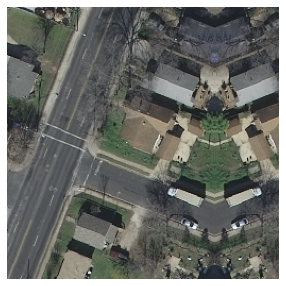

In [12]:
patch_f = path_pch.ls()[0]
patch = open_image(patch_f)
patch.show(figsize=(5,5))

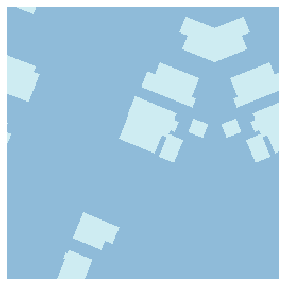

In [13]:
patch_mask = open_mask(path_plb / patch_f.name)
patch_mask.show(figsize=(5,5))

In [14]:
src_size = array(patch_mask.shape[1:])
src_size, patch_mask.data

(array([256, 256]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

# Training databunch

In [15]:
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn):
        # Set div=True to convert from 0/255 pixels to 0/1
        return open_mask(fn, after_open=self.after_open, div=True)
    
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

In [16]:
src = data = learn = selearn = None
gc.collect()
torch.cuda.empty_cache()
bs = 32

In [17]:
src = (
    SegmentationItemListWithDiv.from_folder(path_pch)
    .filter_by_func(is_train_valid)
    .split_by_valid_func(is_valid)
    .label_from_func(lambda f: path_plb / f.name, classes=array(['Not building', 'Building']))
)

In [18]:
transforms = get_transforms(flip_vert=True, max_warp=None)
data = (
    src.transform(transforms, size=src_size, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

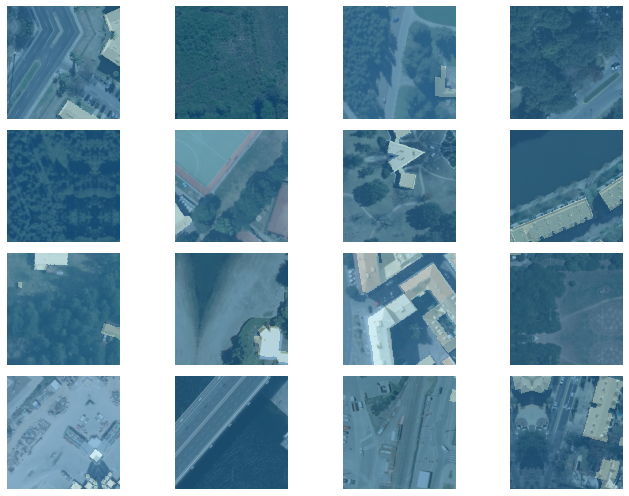

In [19]:
data.show_batch(4, figsize=(10, 7))

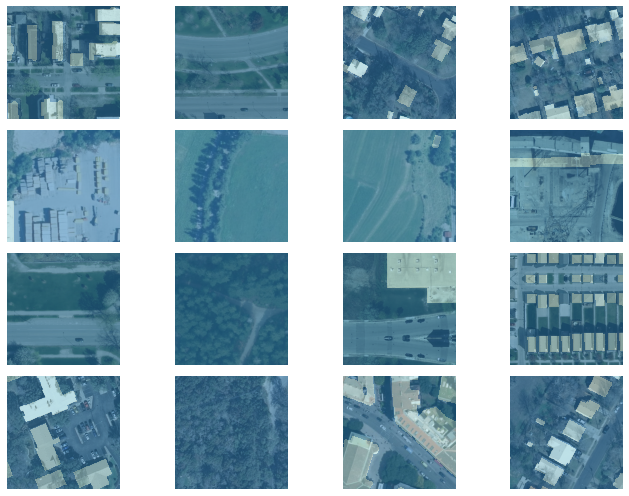

In [20]:
data.show_batch(4, figsize=(10, 7), ds_type=DatasetType.Valid)

# Model

In [21]:
def acc_segment(preds, target):
    target = target.squeeze(1)
    return (preds.argmax(dim=1) == target.squeeze(1)).float().mean()

metrics = acc_segment

In [23]:
from fastai import basic_train, torch_core
from fastai.callbacks import hooks as fai_hooks
from fastai.layers import SequentialEx, batchnorm_2d
from fastai.vision import learner as fai_learner
from fastai.vision.models import unet
import timm.models.senet
from timm.models.senet import SEModule
from torch import nn
import torch.utils.checkpoint as cp


class SEUnetBlock(unet.UnetBlock):

    def __init__(
        self,
        up_in_c: int, 
        x_in_c: int, 
        hook: fai_hooks.Hook, 
        final_div: bool=True, 
        blur: bool=False, 
        leaky: float=None,
        self_attention: bool=False, 
        reduction: int=16,
        **kwargs
    ):
        super().__init__(
            up_in_c, x_in_c, hook, final_div, blur, leaky, self_attention, **kwargs
        )
        channels = self.conv2[0].out_channels
        self.se_module = SEModule(channels, reduction)

    def forward(self, x):
        x = super().forward(x)
        return self.relu(self.se_module(x))


def mod_sizes(m, mods=None, size=(64, 64)):
    with fai_hooks.hook_outputs(mods or m) as hooks:
        x = dummy_eval(m, size)
        return [o.stored.shape for o in hooks]


class BaseUnet(SequentialEx):

    block_cls = unet.UnetBlock

    def __init__(
        self, 
        encoder: nn.Module, 
        n_classes: int, 
        img_size: Tuple[int, int]=(256, 256), 
        y_range: Optional[Tuple[float, float]]=None,
        last_cross: bool=True,
        bottle: bool=False, 
        **kwargs
    ):
        imsize = img_size
        mods = self.encoder_modules(encoder)
        sfs_szs = mod_sizes(encoder, mods, size=imsize)
        sfs_idxs = list(reversed(unet._get_sfs_idxs(sfs_szs)))
        self.sfs = fai_hooks.hook_outputs([mods[i] for i in sfs_idxs], detach=False)
        x = fai_hooks.dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        bottleneck = self.bottleneck(ni, **kwargs).eval()
        x = bottleneck(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), bottleneck]

        for i, idx in enumerate(sfs_idxs):
            not_final = i != len(sfs_idxs) - 1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            unet_block = self.block_cls(
                up_in_c, x_in_c, self.sfs[i], 
                final_div=not_final,
                **kwargs
            ).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: 
            layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: 
            layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: 
            layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def encoder_modules(self, encoder):
        return encoder

    def bottleneck(self, ni, **kwargs):
        return nn.Sequential(
            conv_layer(ni, ni * 2, **kwargs),
            conv_layer(ni * 2, ni, **kwargs),
        )

    def __del__(self):
        if hasattr(self, "sfs"): 
            self.sfs.remove()


class SEUnet(BaseUnet):

    block_cls = SEUnetBlock

    def encoder_modules(self, encoder):
        # SENet groups the first convolution and max pool into a single layer
        return [*encoder[0]] + [*encoder[1:]]


def custom_unet_learner(
    data: DataBunch, 
    arch: Callable, 
    unet: BaseUnet, 
    pretrained: bool=True, 
    memory_efficient: bool=False,
    **learn_kwargs: Any
):
    meta = fai_learner.cnn_config(arch)
    if memory_efficient:
        arch = partial(arch, memory_efficient=True)
    body = fai_learner.create_body(arch, pretrained, cut=meta['cut'])
    size = data.train_ds[0][0].size
    model = torch_core.to_device(
        unet(body, n_classes=data.c, img_size=size, norm_type=None), data.device
    )
    learn = basic_train.Learner(data, model, **learn_kwargs)

    if arch == timm.models.senet.seresnet34:
        # Split similar to fastai's split for resnet34
        split = lambda m: (m[0][3], m[1])
    else:
        split = meta['split']
    learn.split(split)

    if pretrained:
        learn.freeze()
    torch_core.apply_init(model[2], nn.init.kaiming_normal_)
    return learn


seunet_learner = partial(custom_unet_learner, unet=SEUnet)

In [24]:
def soft_dice_loss(input, target, eps=1e-6):
    # Reference: https://www.jeremyjordan.me/semantic-segmentation/#loss
    probability = F.softmax(input, dim=1)
    target_one_hot = F.one_hot(target).squeeze().permute(0, 3, 1, 2).contiguous()
    intersection = probability * target_one_hot

    sum_dim = (2, 3)
    dsc = 2 * intersection.sum(dim=sum_dim) / (
        (target_one_hot * target_one_hot).sum(dim=sum_dim) + (probability * probability).sum(dim=sum_dim) + eps)
    loss = 1 - dsc.mean()

    return loss

In [25]:
import timm.models

learn = seunet_learner(data, timm.models.seresnet34, metrics=metrics, wd=10 ** -3.5)

epoch,train_loss,valid_loss,acc_segment,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


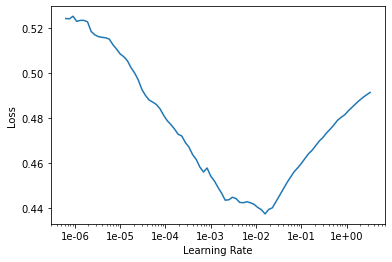

In [37]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr = 1e-3

epoch,train_loss,valid_loss,acc_segment,time
0,0.251807,0.256259,0.943043,50:26
1,0.243770,0.244823,0.951133,48:42
2,0.238819,0.239954,0.955525,48:16
3,0.225594,0.236598,0.957299,48:20
4,0.230255,0.234047,0.957891,48:22
5,0.222067,0.233334,0.958937,48:27


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



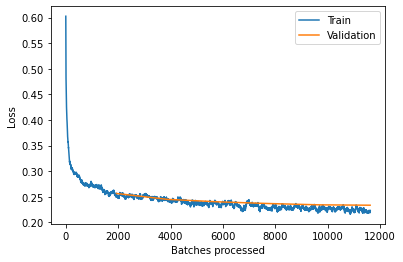

In [27]:
# seresnet34-seres, sd loss, full dataset
lr = 1e-3
learn.fit_one_cycle(6, slice(lr))
learn.recorder.plot_losses()

In [ ]:
learn.save('se-large-1')

In [26]:
learn.load('se-large-1')

Learner(data=ImageDataBunch;

Train: LabelList (62000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Valid: LabelList (10000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Test: None, model=SEUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64,

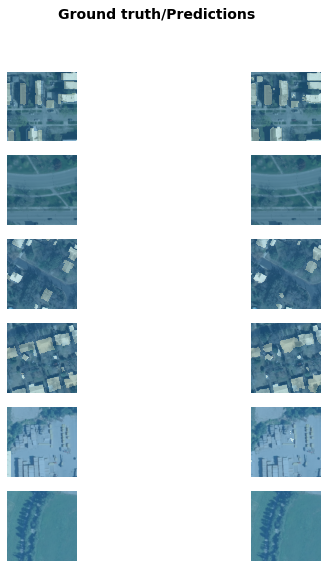

In [28]:
learn.show_results(rows=6, figsize=(8,9))

In [29]:
learn.unfreeze()

In [30]:
lr = 1e-3
lrs = slice(lr / 400, lr / 4)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_segment,time
0,0.106919,0.104044,0.960058,53:18
1,0.107954,0.103688,0.960175,53:09
2,0.111306,0.104025,0.959860,53:09
3,0.106250,0.101358,0.960687,53:09
4,0.101554,0.101226,0.961275,53:11
5,0.101312,0.099779,0.961616,53:13
6,0.095521,0.098914,0.962162,53:17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
learn.save('se-large-2')

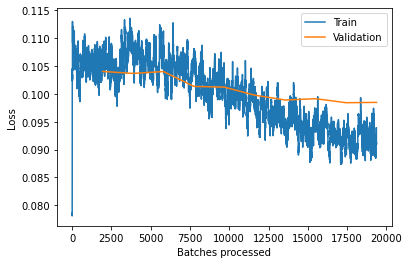

In [32]:
learn.recorder.plot_losses()

In [112]:
lrs = slice(lr / 400, lr / 4)
selearn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_segment,time
0,0.113176,0.104324,0.959656,06:55
1,0.108113,0.101380,0.960984,07:07
2,0.107117,0.102271,0.960796,07:08
3,0.108126,0.098714,0.962284,07:08
4,0.106080,0.106248,0.959274,07:09
5,0.105293,0.106714,0.958815,07:10
6,0.102646,0.100362,0.961333,07:10
7,0.104448,0.103740,0.959715,07:10
8,0.104670,0.107736,0.959538,07:10
9,0.102137,0.103785,0.959950,07:10


In [113]:
selearn.save('se-stage-2')

In [114]:
selearn.load('se-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (8000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Valid: LabelList (2000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Test: None, model=SEUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, e

# Validation metrics

In [26]:
import sklearn.metrics as skm

def acc_iou_curves(y_true, y_score):
    fpr, tpr, thresholds = skm.roc_curve(y_true, y_score)
    num_pos = (y_true == 1).sum().item()
    num_neg = len(y_true) - num_pos
    
    fp = fpr * num_neg
    tp = tpr * num_pos
    fn = (1 - tpr) * num_pos
    tn = (1 - fpr) * num_neg
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    iou = tp / (tp + fp + fn)
    return acc, iou, thresholds

In [27]:
valid_patcher = Patcher(5000, 1024, 0.5)
for tile in path_img.ls():
    if is_valid(tile):
        valid_patcher.save_patches(tile, path / 'valid_patches')
        valid_patcher.save_patches(path_lbl / tile.name, path / 'valid_pl')

In [28]:
from collections import defaultdict


def valid_stats(patcher, valid_items, valid_preds, ctx_weight_size_pct=0.8):
    tile_name = lambda i: i[0].name.split('_', 1)[0]
    
    preds = defaultdict(list)
    for item, pred in sorted(zip(valid_items, valid_preds)):
        preds[item.name.split('_', 1)[0]].append(pred)
    
    valid_stitched = {}
    for tile, patches in preds.items():
        label = open_image(path_lbl / f'{tile}.tif').data[0]
        stitched = patcher.stitch_patches_pad(patches, ctx_weight_size_pct=ctx_weight_size_pct)[1]
        mask = stitched != 0
        valid_stitched[tile] = label[mask].flatten(), stitched[mask].flatten()
        
    y_true, y_score = zip(*valid_stitched.values())
    acc, iou, thresholds = acc_iou_curves(torch.cat(y_true), torch.cat(y_score))
    max_idx = np.argmax(iou)
    return {
        'max_iou': iou[max_idx],
        'accuracy': acc[max_idx],
        'threshold': thresholds[max_idx],
    }

In [29]:
valid_data = (
    SegmentationItemListWithDiv
    .from_folder(path / 'valid_patches')
    
    .filter_by_func(lambda p: patch_idx(p) >= 40)
    .split_by_valid_func(lambda _: True)
    
    .label_from_func(lambda f: path / 'valid_pl' / f.name, classes=array(['Not building', 'Building']))
    .transform(transforms, size=(1024, 1024), tfm_y=True)
    .databunch(bs=2)
    .normalize(imagenet_stats)    
)

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [29]:
learn.load('se-large-2')

Learner(data=ImageDataBunch;

Train: LabelList (62000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Valid: LabelList (10000 items)
x: SegmentationItemListWithDiv
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelListWithDiv
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: AerialImageDataset/train/large_patches;

Test: None, model=SEUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64,

In [32]:
learn.data = valid_data
valid_preds = learn.get_preds(activ=partial(F.softmax, dim=1))

In [33]:
# Evaluate over the validation set in two parts to avoid memory issues
torch.save((learn.data.valid_ds.items, valid_preds[0]), path / 'valid_preds/se-large-2/preds2.pt')

In [29]:
items1, preds1 = torch.load(path / 'valid_preds/se-large-2/preds1.pt')
items2, preds2 = torch.load(path / 'valid_preds/se-large-2/preds2.pt')

In [30]:
all_items = np.concatenate([items1, items2])
all_preds = torch.cat([preds1, preds2])

In [31]:
preds1 = preds2 = None
gc.collect()

64052

In [32]:
# se-large-2
valid_stats(valid_patcher, all_items, all_preds, ctx_weight_size_pct=0.8)

{'max_iou': 0.7733400923053613,
 'accuracy': 0.9642561536,
 'threshold': 0.4163644}

# Generate Test Predictions

In [7]:
path_test = Path('AerialImageDataset/test/images')
path_test.ls()

[PosixPath('AerialImageDataset/test/images/sfo36.tif'),
 PosixPath('AerialImageDataset/test/images/innsbruck23.tif'),
 PosixPath('AerialImageDataset/test/images/tyrol-e16.tif'),
 PosixPath('AerialImageDataset/test/images/sfo27.tif'),
 PosixPath('AerialImageDataset/test/images/bloomington10.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham32.tif'),
 PosixPath('AerialImageDataset/test/images/tyrol-e8.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham35.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham8.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham20.tif'),
 PosixPath('AerialImageDataset/test/images/tyrol-e3.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham29.tif'),
 PosixPath('AerialImageDataset/test/images/bellingham1.tif'),
 PosixPath('AerialImageDataset/test/images/sfo15.tif'),
 PosixPath('AerialImageDataset/test/images/sfo19.tif'),
 PosixPath('AerialImageDataset/test/images/innsbruck20.tif'),
 PosixPath('AerialImageDataset/tes

In [51]:
test_patcher = Patcher(5000, 1024, 0.5)
for tile in path_test.ls():
    test_patcher.save_patches(tile, path / 'test_patches')

In [17]:
def generate_test_preds(learner, patcher, tile, out_d, ctx_weight_size_pct=0.8, threshold=0.5):
    data = (
        SegmentationItemListWithDiv
        .from_folder(path / 'test_patches')
        .filter_by_func(lambda p: p.name.split('_', 1)[0] == tile.stem)
        .split_by_valid_func(lambda _: True)
        .label_empty()        
        .databunch(bs=2)
        .normalize(imagenet_stats)
    )
    learner.data = data
    preds = learner.get_preds(activ=partial(F.softmax, dim=1))[0]
    item_patches = sorted(zip(data.valid_ds.items, preds))
    stitched = patcher.stitch_patches_pad([p for _, p in item_patches], ctx_weight_size_pct=ctx_weight_size_pct)[1]
    img = Image((stitched > threshold).float().unsqueeze(0))
    img.save(out_d / tile.name)

In [53]:
for tile in path_test.ls():
    out_d = path / 'test_preds'
    if not (out_d / tile.name).exists():
        generate_test_preds(learn, test_patcher, tile, out_d, threshold=0.4163644)

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
